# Dataset download links:
# - [Wordle dataset](https://www.kaggle.com/datasets/shamiljamion/wordle-letters)
# - [Handwritten letters dataset](https://www.kaggle.com/datasets/sankalpsrivastava26/capital-alphabets-28x28)

# Idea is to pre-train a CNN on the handwritten letters dataset, then fine-tune it on the Wordle dataset.

# Data Cleaning for handwritten letters dataset
- First combine val and train sets
- Second, try to filter invalid images, which contains a lot of white pixels

In [1]:
import os
import shutil

dataset_path = "dataset"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "validation")
test_path = os.path.join(dataset_path, "test")

# Combine train val sets

In [2]:
# Combine train and validation sets

# First, find the highest existing index in train
def max_index_in(dirpath):
    idxs = []
    for fn in os.listdir(dirpath):
        name, _ = os.path.splitext(fn)
        if name.isdigit():
            idxs.append(int(name))
    return max(idxs) if idxs else -1

for class_name in os.listdir(val_path):
    src_dir = os.path.join(val_path, class_name)
    dst_dir = os.path.join(train_path, class_name)
    os.makedirs(dst_dir, exist_ok=True)

    last_img = max_index_in(dst_dir)  # e.g. starts at -1 if empty

    for idx, filename in enumerate(os.listdir(src_dir), start=1):
        name, ext = os.path.splitext(filename)
        new_index = last_img + idx
        new_name  = f"{new_index:06d}{ext}"
        src = os.path.join(src_dir, filename)
        dst = os.path.join(dst_dir, new_name)
        os.rename(src, dst)

# Remove validation directory
shutil.rmtree(val_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset\\validation'

# Remove invalid Mostly white images

Removing mostly white image: dataset\train\A\000074.png
Removing mostly white image: dataset\train\A\000102.png
Removing mostly white image: dataset\train\A\000171.png
Removing mostly white image: dataset\train\A\000176.png
Removing mostly white image: dataset\train\A\000203.png
Removing mostly white image: dataset\train\A\000393.png
Removing mostly white image: dataset\train\A\000435.png
Removing mostly white image: dataset\train\A\000495.png
Removing mostly white image: dataset\train\A\000610.png
Removing mostly white image: dataset\train\A\000732.png
Removing mostly white image: dataset\train\A\000773.png
Removing mostly white image: dataset\train\A\000839.png
Removing mostly white image: dataset\train\A\000858.png
Removing mostly white image: dataset\train\A\001025.png
Removing mostly white image: dataset\train\A\001063.png
Removing mostly white image: dataset\train\A\001126.png
Removing mostly white image: dataset\train\A\001160.png
Removing mostly white image: dataset\train\A\001

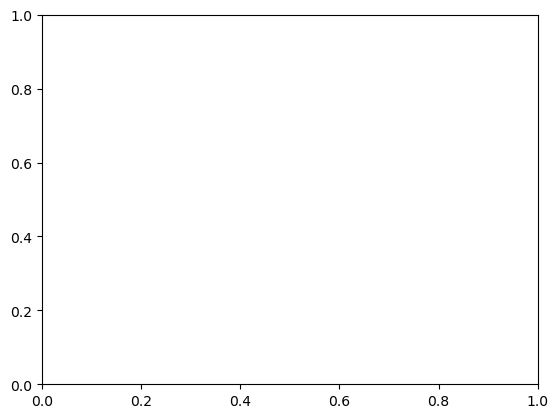

In [4]:
# Loop through the train directory and remove images that are mostly white
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

threshold=0.2

def is_image_mostly_white(image_path):
    with Image.open(image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        arr = np.array(img)
        white_pixels = np.sum(arr > 240)  # Count pixels that are nearly white
        total_pixels = arr.size
        return (white_pixels / total_pixels) > threshold

plt.ion()
fig, ax = plt.subplots()

# Remove mostly white images from train class
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        if is_image_mostly_white(file_path):
            # # Show
            # img = Image.open(file_path).convert("RGB")
            # plt.imshow(img)
            # plt.axis('off')
            # plt.show()

            print(f"Removing mostly white image: {file_path}")
            os.remove(file_path)


# Do the same for test class
# Show one example of a mostly white image
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        if is_image_mostly_white(file_path):
            # # Show
            # img = Image.open(file_path).convert("RGB")
            # plt.imshow(img)
            # plt.axis('off')
            # plt.show()

            print(f"Removing mostly white image: {file_path}")
            os.remove(file_path)

# Check remaining images in each class

In [9]:
# Print remaining images in each class
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")

A: 2000 images
B: 2000 images
C: 2000 images
D: 1974 images
E: 1953 images
F: 1992 images
G: 1934 images
H: 2000 images
I: 2000 images
J: 2000 images
K: 2000 images
L: 2000 images
M: 2000 images
N: 2000 images
O: 2000 images
P: 2000 images
Q: 2000 images
R: 2000 images
S: 2000 images
T: 2000 images
U: 2000 images
V: 2000 images
W: 2000 images
X: 2000 images
Y: 2000 images
Z: 2000 images


# Calculate mean and std of the dataset

In [3]:
# Check the mean and std of the dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Build transform exactly as you'll use it in training EXCEPT Normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Use ImageFolder: expects class subfolders (A-Z) as you have
dataset = datasets.ImageFolder(root=train_path, transform=transform)

loader = DataLoader(dataset, batch_size=64, num_workers=4, pin_memory=True)  # tune batch_size/num_workers

# Record
dtype = torch.float64
total_sum = torch.zeros(1, dtype=dtype)
total_sq_sum = torch.zeros(1, dtype=dtype)
total_pixels = 0

for imgs, _ in loader:
    imgs = imgs.to(dtype=dtype)
    b, c, h, w = imgs.shape

    # If first batch, make accumulators of the correct channel size
    if total_sum.numel() != c:
        total_sum = torch.zeros(c, dtype=dtype)
        total_sq_sum = torch.zeros(c, dtype=dtype)

    total_sum += imgs.sum(dim=[0,2,3])        # per-channel sum
    total_sq_sum += (imgs ** 2).sum(dim=[0,2,3])
    total_pixels += b * h * w

mean = total_sum / total_pixels               # tensor of length C
var  = (total_sq_sum / total_pixels) - (mean ** 2)
std  = torch.sqrt(var)

print("mean:", mean.tolist())
print("std: ", std.tolist())


C:\Users\Aozy\anaconda3\envs\wordle-solver\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


mean: [0.11069265479854667]
std:  [0.26611940423598746]


# Also preprocess the Wordle dataset
# - Convert to grayscale to match the handwritten letters dataset

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import cv2
from alphabet_classifier.helper_functions import wordle_cell_preprocessing
from tqdm import tqdm

# Input/output roots
input_root  = Path("alphabet_classifier/finetune_dataset")
output_root = Path("alphabet_classifier/finetune_dataset_preprocessed")

# Make sure output dir exists
output_root.mkdir(parents=True, exist_ok=True)

# Which extensions to process
extensions = {".png", ".jpg", ".jpeg"}

# Walk input tree and collect image paths
image_paths = [p for p in input_root.rglob("*")
               if p.suffix.lower() in extensions]
print(f"Found {len(image_paths)} images to preprocess.")

# Loop & process
for img_path in tqdm(image_paths, desc="Threshold & resize"):
    # Mirror directory structure
    rel_path = img_path.relative_to(input_root)
    out_path = output_root / rel_path
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # Load image
    img = cv2.imread(img_path)
    # Load image and convert to grayscale
    thresh = wordle_cell_preprocessing(img)

    # Check if background is white or grey
    # CNN is trained on black background white letters
    # So need to invert the image if background is white or grey
    mean_pixel_value = cv2.mean(thresh)[0]
    if mean_pixel_value > 127:
        thresh = cv2.bitwise_not(thresh)

    # Fill in black at the boarders of 4px
    # This is due to some hand curated dataset having a white square around the image
    thresh[:4, :] = 0
    thresh[-4:, :] = 0
    thresh[:, :4] = 0
    thresh[:, -4:] = 0

    # Save
    cv2.imwrite(str(out_path), thresh)


Found 208 images to preprocess.


Threshold & resize: 100%|██████████| 208/208 [00:00<00:00, 280.65it/s]


In [2]:
img_path = "C:\\Users\\Aozy\\Desktop\\raw_cells\\raw_r0_c1.jpg"
# Load image
img = cv2.imread(img_path)
# Load image and convert to grayscale
thresh = wordle_cell_preprocessing(img)

# Check if background is white or grey
# CNN is trained on black background white letters
# So need to invert the image if background is white or grey
mean_pixel_value = cv2.mean(thresh)[0]
if mean_pixel_value > 127:
    thresh = cv2.bitwise_not(thresh)

# Fill in black at the boarders of 4px
# This is due to some hand curated dataset having a white square around the image
thresh[:4, :] = 0
thresh[-4:, :] = 0
thresh[:, :4] = 0
thresh[:, -4:] = 0

# Save
out_path = "C:\\Users\\Aozy\\Desktop\\raw_cells\\preprocessed_raw_r0_c1.jpg"
cv2.imwrite(str(out_path), thresh)

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
